In [32]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

import SimpleITK as stk

In [33]:
root = "/Users/STUFF/lungnode/subset0/"
output_path = "../Processedm2/nodule_mask/"

In [34]:
def load_mhd(file):
    mhdimage = stk.ReadImage(root+file)
    ct_scan = stk.GetArrayFromImage(mhdimage)    
    origin = np.array(mhdimage.GetOrigin())      
    space = np.array(mhdimage.GetSpacing())      
    return ct_scan, origin, space

In [35]:
######### Test CT-Scans ########
test1 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
test2 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd"
test3 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd"
test4 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd"

tests = [test1, test2, test3, test4]

In [36]:
###### Test ######
for i,test in enumerate(tests):
    exec(f"ct{i+1}, origin{i+1}, space{i+1} = load_mhd(test)")

print("CT_SCAN SHAPE:",ct4.shape)
print("Origin:",origin4)
print("Space:",space4)
print("MAX:",ct4.max())
print("MIN:",ct4.min())

CT_SCAN SHAPE: (588, 512, 512)
Origin: [-157.24316406 -281.24316406 -336.        ]
Space: [0.51367188 0.51367188 0.5       ]
MAX: 3071
MIN: -1024


In [37]:
test_imgs = [ct1, ct2, ct3, ct4]
origins = [origin1, origin2, origin3, origin4]
spaces = [space1, space2, space3, space4]

In [38]:
def display(imgs, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//4 if n%4==0 else (n//4)+1
    plt.figure(figsize=(25,14))
    for i,img in enumerate(imgs):
        plt.subplot(r,4,i+1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img, cmap=cmap)

In [39]:
def display_mask(imgs, masks, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//2 if n%2==0 else (n//2)+1
    plt.figure(figsize=(20,40))
    for i,(img, mask) in enumerate(zip(imgs,masks)):
        plt.subplot(r,2,i+1)
        ig = np.hstack((img, mask))
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(ig, cmap=cmap)

In [40]:
annotations = pd.read_csv("/Users/STUFF/lungnode/annotations.csv")

In [41]:
def make_mask(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.circle(mask, (int(center[0]),int(center[1])), diam//2, 255, -1)
    return mask

In [42]:
masks = []
imgs = []
tt = -1
v_centers = []
v_diameters = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for i, (img, filename, origin, spacing) in enumerate(zip(test_imgs, tests, origins, spaces)):
    width = img.shape[2]
    height = img.shape[1]
    sid = filename.replace(".mhd","")
    nodule_df = annotations[annotations["seriesuid"]==sid]

    p_vcenter = None
    tt += 1
    for i, mask_i in nodule_df.iterrows():
        node_x = int(mask_i["coordX"])
        node_y = int(mask_i["coordY"])
        node_z = int(mask_i["coordZ"])
        diam = int(mask_i["diameter_mm"])
        
        center = np.array([node_x, node_y, node_z])   
        v_center = np.rint((center-origin)/spacing)   
        v_diam = int(diam/spacing[0])+5
        print(v_center)
        img_norm = cv2.normalize(img[int(v_center[2]),:,:], None, 0, 255, cv2.NORM_MINMAX)
        
        
        mask = make_mask(img_norm, v_center, v_diam)
        print(v_diam)
        if v_diam>18:
            img_norm2 = cv2.normalize(img[(int(v_center[2])-1),:,:], None, 0, 255, cv2.NORM_MINMAX)
            mask2 = make_mask(img_norm2, v_center, v_diam-1)
            img_norm3 = cv2.normalize(img[(int(v_center[2])+1),:,:], None, 0, 255, cv2.NORM_MINMAX)
            mask3 = make_mask(img_norm3, v_center, v_diam-1)
            img_norm2 = clahe.apply(img_norm2.astype(np.uint8))
            img_norm3 = clahe.apply(img_norm3.astype(np.uint8))
            masks.append(mask2)
            masks.append(mask3)
            imgs.append(img_norm2)
            imgs.append(img_norm3)
            v_centers.append(list(v_center))
            v_centers.append(list(v_center))
            v_diameters.append(v_diam)
            v_diameters.append(v_diam)
        
        
        img_norm = clahe.apply(img_norm.astype(np.uint8))
        
        masks.append(mask)
        imgs.append(img_norm)
        v_centers.append(list(v_center))
        v_diameters.append(v_diam)

[111. 346.  33.]
13
[322. 381. 101.]
19
[ 83. 307.  92.]
19
[114. 348.  90.]
27
[ 96. 205. 288.]
20


### Nodule Segmentation and Mask Generation

This script processes CT images to generate nodule masks. It normalizes slices, applies CLAHE for contrast enhancement, and creates spherical masks based on annotated coordinates and diameters. For large nodules, masks for adjacent slices are also generated.

Key Steps:
1. Normalize and enhance slices using CLAHE.
2. Generate nodule masks from annotated coordinates and diameters.
3. Create additional masks for large nodules from adjacent slices.

Processed masks and images are stored for further analysis.

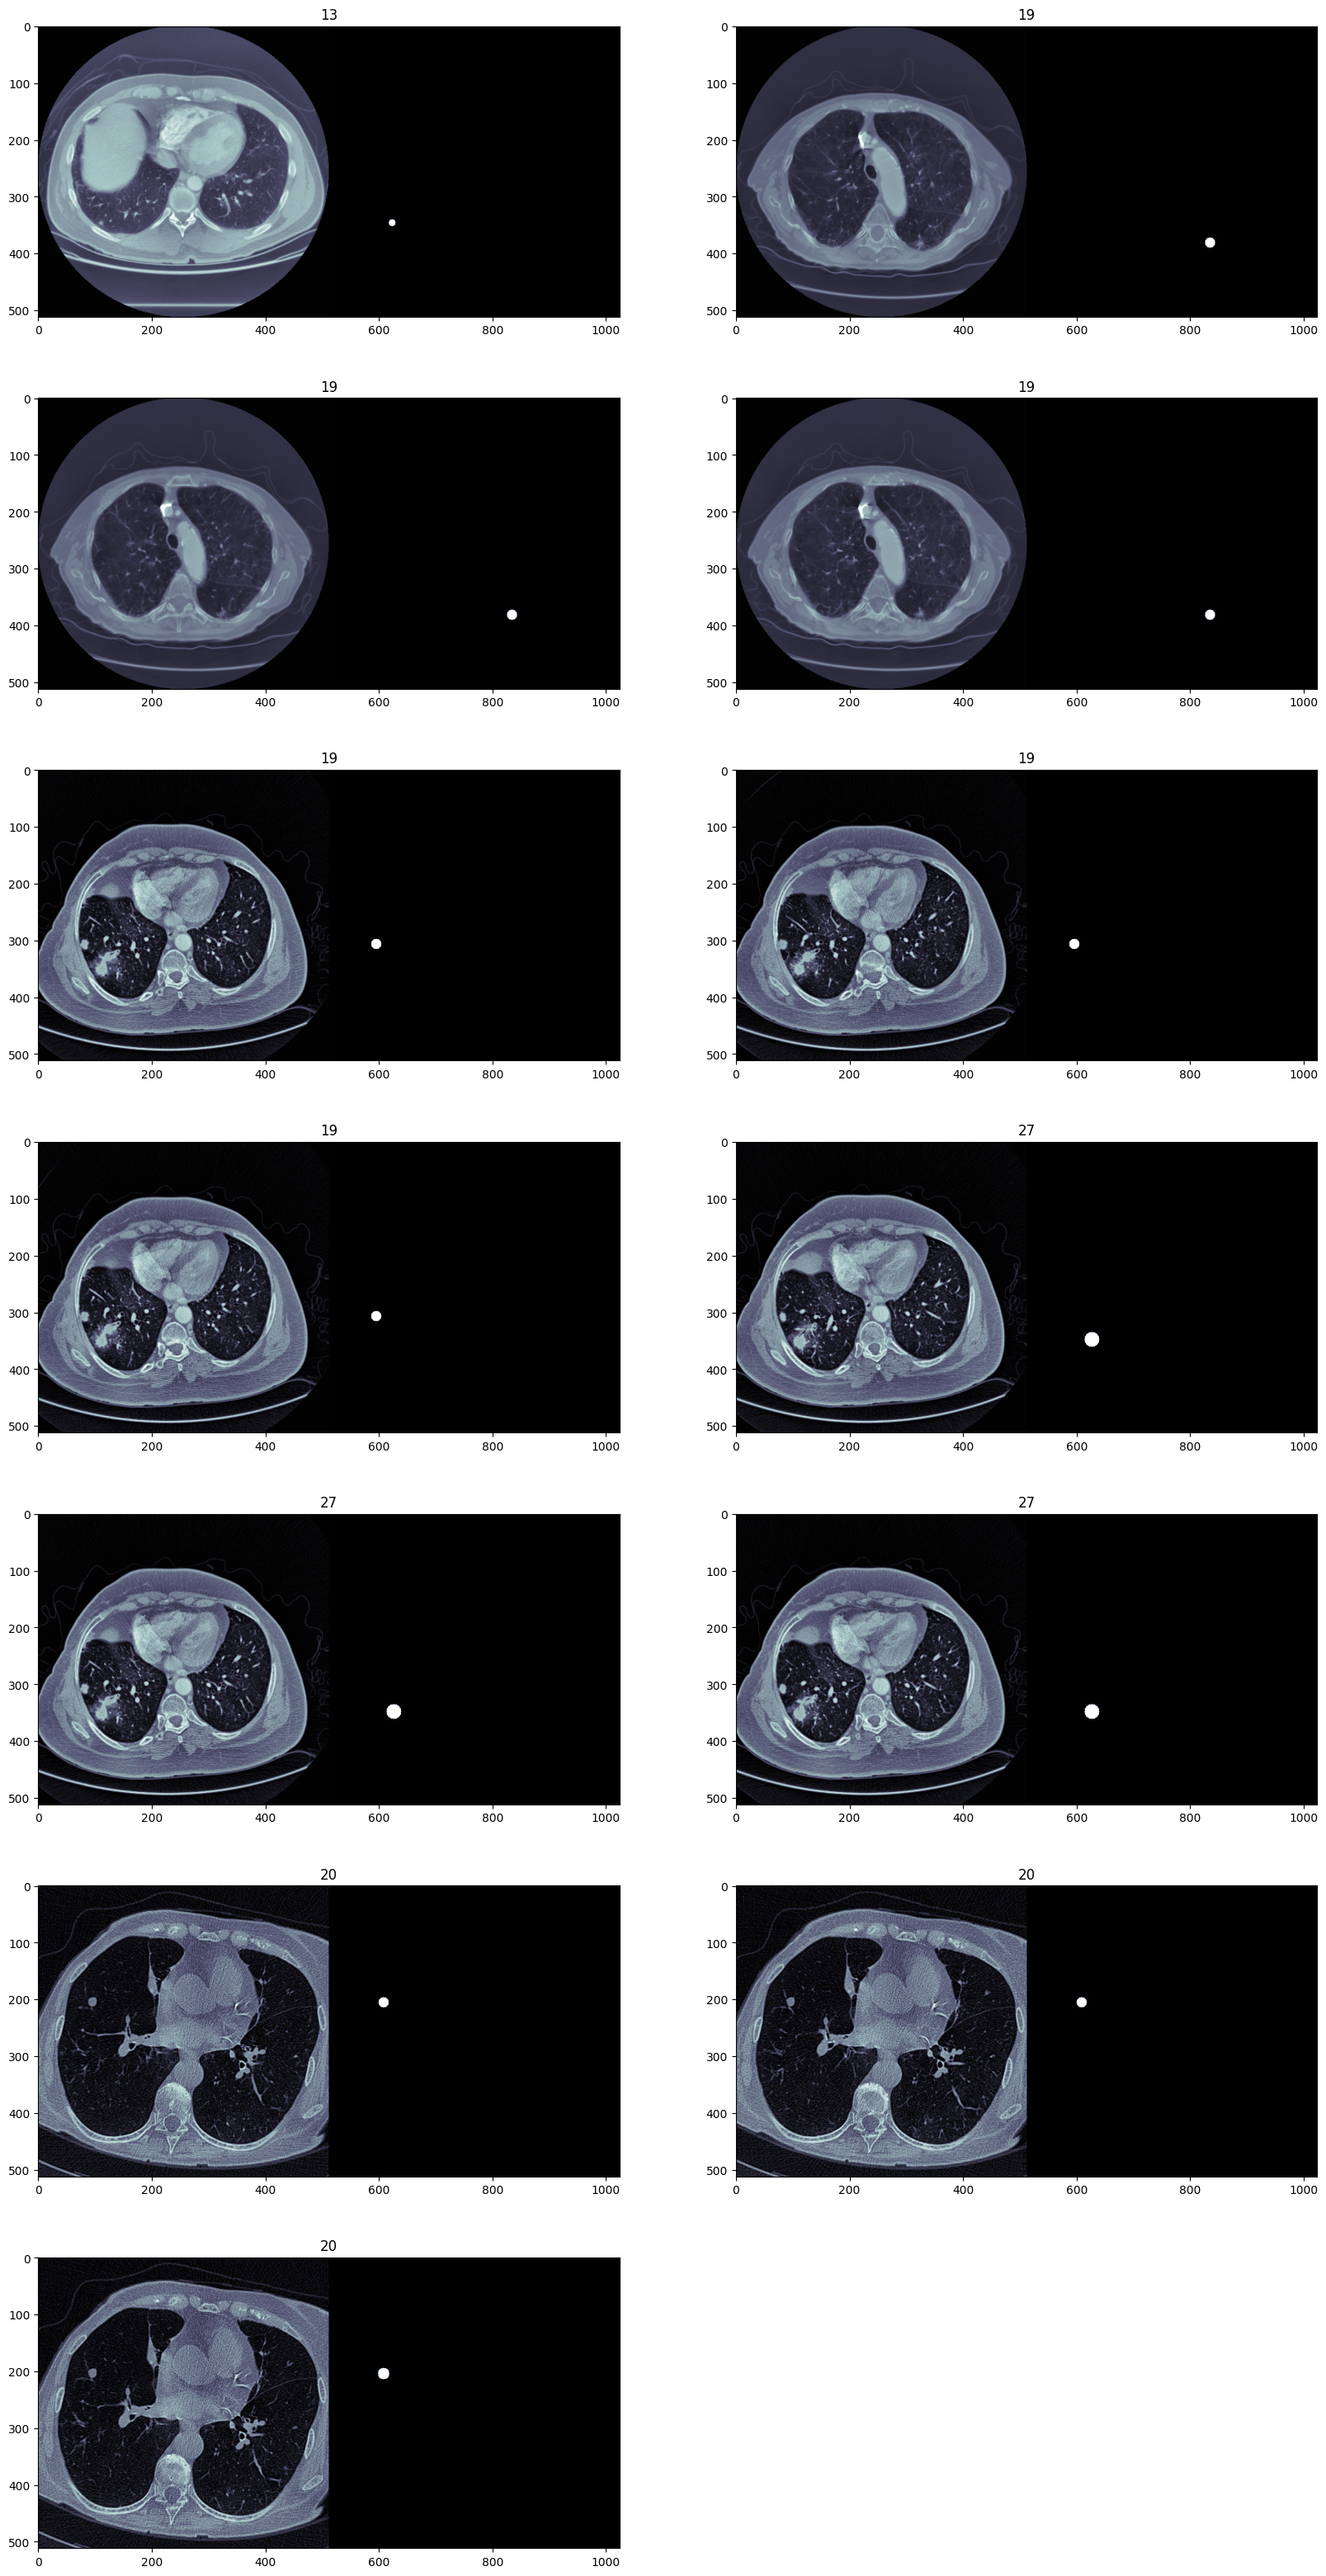

In [43]:
display_mask(imgs, masks, titles=v_diameters)

In [44]:
masksi = []
from sklearn.cluster import KMeans
for i,m in zip(imgs,masks):
    e = cv2.bitwise_and(i,i,mask=cv2.dilate(m,kernel=np.ones((5,5))))
    pts = e[e>0]
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(pts,(len(pts),1)))
    centroids = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centroids)
    ret, lung_nod = cv2.threshold(e, threshold, 255, cv2.THRESH_BINARY)
    masksi.append(lung_nod)

### Nodule Segmentation Using KMeans Clustering

This script processes nodule masks by applying KMeans clustering to extract lung nodules. For each mask, it dilates the mask, applies KMeans clustering to the extracted pixel values, and calculates a threshold to segment the nodule region.

Key Steps:
1. **Apply mask dilation** to expand the region of interest.
2. **KMeans clustering** is applied to the pixel values within the mask.
3. **Thresholding** is performed to segment the lung nodule based on the clustering results.

The final segmented nodules are stored in `masksi` for further analysis.

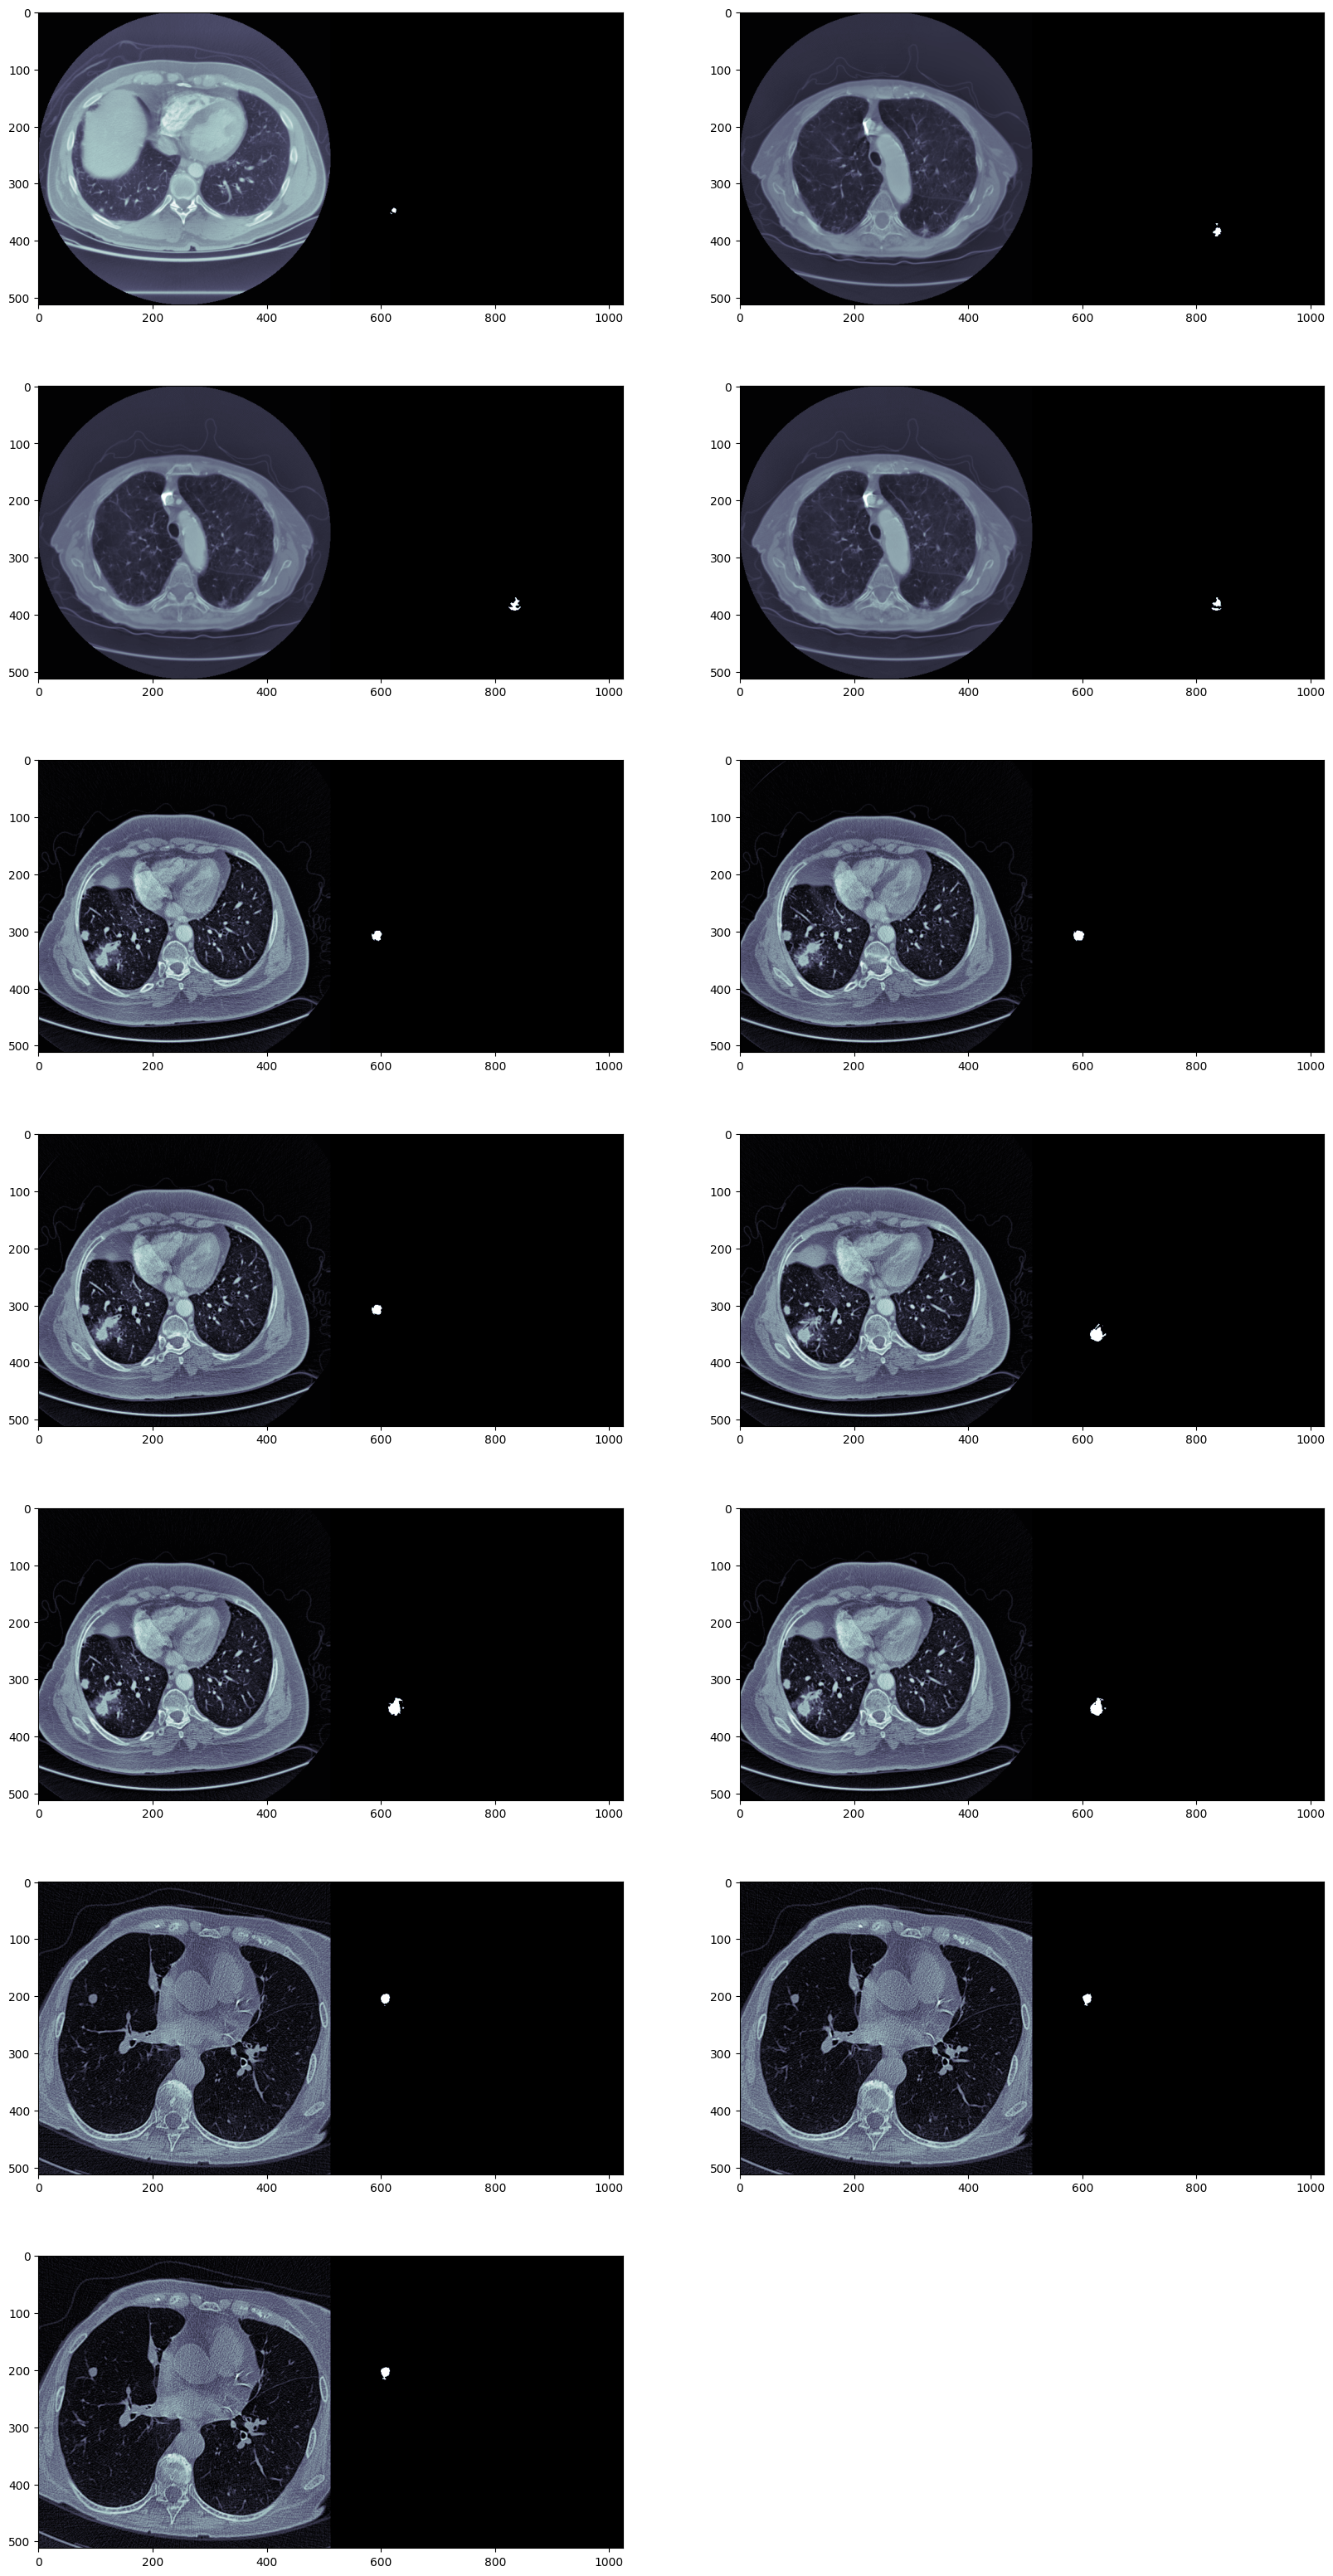

In [45]:
display_mask(imgs, masksi)